In [1]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pickle

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

models_path = '/tmp/tensorflow_models/MNIST_1FCDrop_Sigmoid_2'

# Parameters
learning_rate = 1.0
training_epochs = 20
batch_size = 10
display_step = 1
log_step = 100

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_output = 10 # MNIST total classes (0-9 digits)
n_hidden_1 = 100 # 1st layer number of features

# TF Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y_ = tf.placeholder(tf.float32, [None, 10], name='LabelData')
keep_prob = tf.placeholder(tf.float32)

# Helper functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Store layers weight & bias
weights = {
    'W1': weight_variable([n_input, n_hidden_1]),
    'W2': weight_variable([n_hidden_1, n_output])
}
biases = {
    'b1': bias_variable([n_hidden_1]),
    'b2': bias_variable([n_output])    
}


# Create model
def build_model(x, weights, biases):
    # Hidden layer with ReLU activation
    layer_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    # Output layer
    out_layer = tf.add(tf.matmul(layer_1_drop, weights['W2']), biases['b2'])
    return out_layer


# Encapsulating all ops into scopes, making Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Build model
    pred = build_model(x, weights, biases)

with tf.name_scope('Loss'):
    # Sigmoid cross entropy (cost function)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(pred, y_))
    # NOTE:
    # Since out_layer has NOT invoked sigmoid, leverage TF optimized function 
    # "sigmoid_cross_entropy_with_logits" to calculate cost

with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss)    
    
with tf.name_scope('Accuracy'):
    # Accuracy
    accuracy = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
## Training

# Initializing the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver()

train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

with tf.Session() as sess:
    sess.run(init)
    log_avg_costs = list()
    # Training cycle
    for epoch in tqdm(range(training_epochs), ascii=True): 
        epoch_avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_cost, _ = sess.run([loss, train_step], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            epoch_avg_cost += train_cost / total_batch
            log_avg_costs.append(train_cost)
            if (i+1) % log_step == 0:
                train_cost_history.append(np.mean(log_avg_costs))
                log_avg_costs[:] = []
                val_cost, val_accuracy = sess.run([loss, accuracy], feed_dict={x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
                validation_cost_history.append(val_cost)
                validation_accuracy_history.append(val_accuracy)
        
        # Display training cost & validation accuracy per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: {}, cost= {:.9f}".format(epoch+1, epoch_avg_cost))

    print("Optimization Finished!")  
    save_path = saver.save(sess, models_path + '/model.ckpt')
    print("Model save in file: %s" % save_path)
    with open(models_path + '/history.pickle', "wb") as f:
        pickle.dump((train_cost_history, validation_cost_history, validation_accuracy_history), f)    
    
    # Test model
    # Calculate accuracy
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

  5%|5         | 1/20 [00:15<04:59, 15.76s/it]

Epoch: 1, cost= 0.077605107


 10%|#         | 2/20 [00:30<04:38, 15.50s/it]

Epoch: 2, cost= 0.056302806


 15%|#5        | 3/20 [00:45<04:20, 15.33s/it]

Epoch: 3, cost= 0.050415750


 20%|##        | 4/20 [01:01<04:08, 15.52s/it]

Epoch: 4, cost= 0.046875138


 25%|##5       | 5/20 [01:19<04:02, 16.15s/it]

Epoch: 5, cost= 0.045209049


 30%|###       | 6/20 [01:37<03:55, 16.81s/it]

Epoch: 6, cost= 0.042995562


 35%|###5      | 7/20 [01:54<03:39, 16.91s/it]

Epoch: 7, cost= 0.041901267


 40%|####      | 8/20 [02:09<03:16, 16.41s/it]

Epoch: 8, cost= 0.041301659


 45%|####5     | 9/20 [02:24<02:55, 15.94s/it]

Epoch: 9, cost= 0.040087056


 50%|#####     | 10/20 [02:39<02:35, 15.59s/it]

Epoch: 10, cost= 0.039452998


 55%|#####5    | 11/20 [02:54<02:18, 15.39s/it]

Epoch: 11, cost= 0.038155285


 60%|######    | 12/20 [03:11<02:06, 15.82s/it]

Epoch: 12, cost= 0.038308975


 65%|######5   | 13/20 [03:26<01:49, 15.68s/it]

Epoch: 13, cost= 0.036975385


 70%|#######   | 14/20 [03:42<01:34, 15.68s/it]

Epoch: 14, cost= 0.036946021


 75%|#######5  | 15/20 [03:58<01:18, 15.70s/it]

Epoch: 15, cost= 0.036356508


 80%|########  | 16/20 [04:14<01:03, 15.96s/it]

Epoch: 16, cost= 0.036647380


 85%|########5 | 17/20 [04:29<00:47, 15.68s/it]

Epoch: 17, cost= 0.034922436


 90%|######### | 18/20 [04:44<00:31, 15.54s/it]

Epoch: 18, cost= 0.034968017


 95%|#########5| 19/20 [04:59<00:15, 15.33s/it]

Epoch: 19, cost= 0.035079606


100%|##########| 20/20 [05:14<00:00, 15.30s/it]

Epoch: 20, cost= 0.035390036
Optimization Finished!


Model save in file: /tmp/tensorflow_models/MNIST_1FCDrop_Sigmoid_2/model.ckpt
Test Accuracy: 0.9681


In [3]:
# Restore Model when needed
train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, models_path + '/model.ckpt')
    print("Model restored.")
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    with open(models_path + '/history.pickle', "rb") as f:
        train_cost_history, validation_cost_history, validation_accuracy_history = pickle.load(f)

Model restored.
Test Accuracy: 0.9681


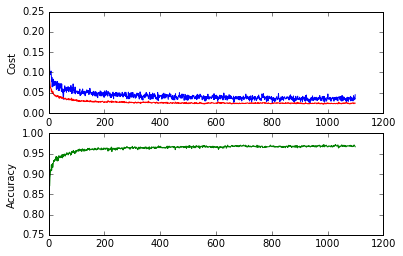

In [4]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure() 
# create figure window
gs = gridspec.GridSpec(2, 1)
# Creates grid 'gs' of 2 rows and 1 columns 
ax = plt.subplot(gs[0, 0])
# Adds subplot 'ax' in grid 'gs' at position [0,0]
ax.set_ylabel('Cost') 
ax.set_xlabel('Iterations') 
ax.plot(train_cost_history, 'b-')
ax.plot(validation_cost_history, 'r-')
fig.add_subplot(ax) 

bx = plt.subplot(gs[1, 0])
bx.set_ylabel('Accuracy') 
bx.plot(validation_accuracy_history, 'g-')
fig.add_subplot(bx)

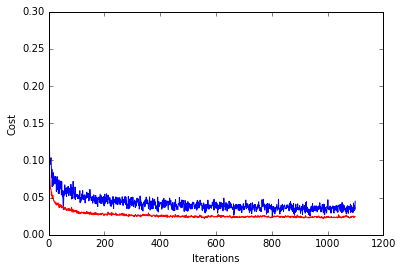

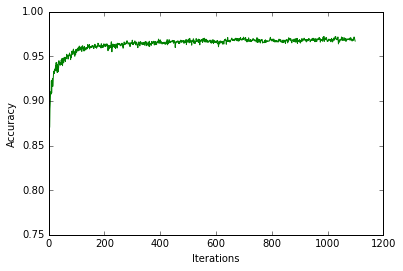

In [5]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

plt.figure(1)
plt.plot(train_cost_history,'b-')
plt.plot(validation_cost_history, 'r-')
plt.ylabel('Cost')
plt.xlabel('Iterations')
pylab.ylim([0, 0.3])

plt.figure(2)
plt.plot(validation_accuracy_history, 'g-')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')